## Data Science Workflows

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

holdout.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [16]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [17]:
def process_dataframe(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    df = create_dummies(df, ["Age_categories", "Fare_categories","Title", "Cabin_type", "Sex"])
    return df

train = process_dataframe(train)
holdout = process_dataframe(holdout)

train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Sex_female,Sex_male
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,0,0,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,1,0,0,0,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,0,0,1,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,1,0,0,0,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0,0,0,0,0,0,1,0,1


In [18]:
#Inspecting the type of the columns

train[['SibSp', 'Parch']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   SibSp   891 non-null    int64
 1   Parch   891 non-null    int64
dtypes: int64(2)
memory usage: 14.0 KB


The `SibSp` column shows the number of siblings and/or spouses each passenger had on board, while the `Parch` columns shows the number of parents or children each passenger had onboard. Neither column has any missing values.

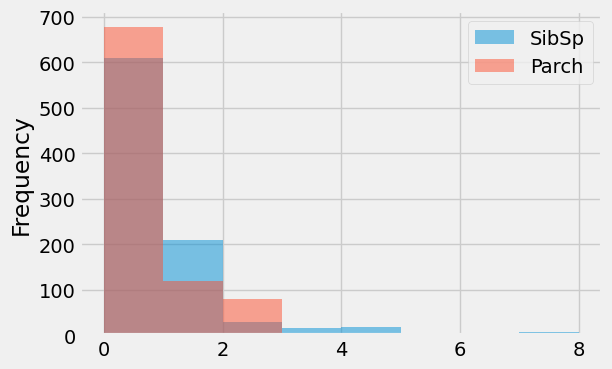

In [19]:
# Using histograms to view the distribution of values in the columns
%matplotlib inline
plt.style.use('fivethirtyeight')


train['Family_count'] = train['SibSp'] + train['Parch']
holdout['Family_count'] = holdout['SibSp'] + holdout['Parch']
cols = ["SibSp","Parch"]

train[cols].plot.hist(cols, alpha = 0.5, bins = 8)


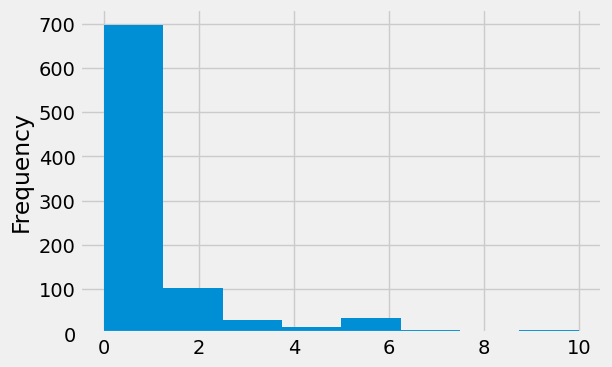

In [20]:
train['Family_count'].plot.hist('Family_count', alpha = 1, bins = 8, rwidth = 10)

Text(0, 0.5, 'survival rate')

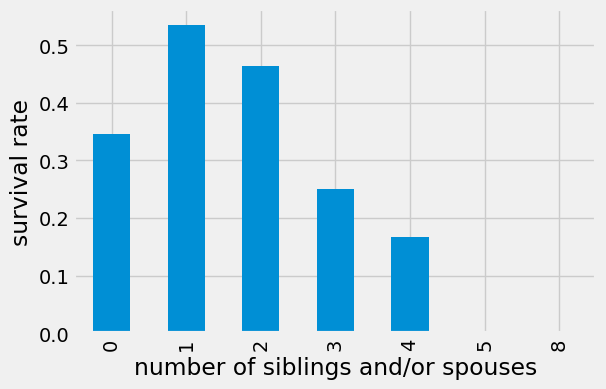

In [21]:
# Use pivot tables to look at the survival rate for different values of the columns

siblings_survived = pd.pivot_table(train, values = 'Survived', index  = 'SibSp', aggfunc = 'mean')
siblings_survived.plot.bar(legend=None)
plt.xlabel('number of siblings and/or spouses')
plt.ylabel('survival rate')

Text(0, 0.5, 'survival rate')

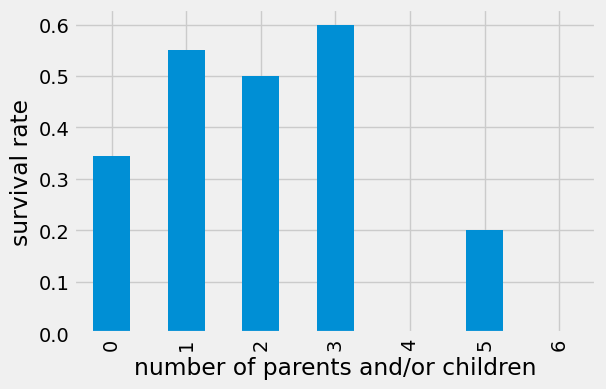

In [22]:
parch_survived = pd.pivot_table(train, values = 'Survived', index  = 'Parch', aggfunc = 'mean')
parch_survived.plot.bar(legend=None)
plt.xlabel('number of parents and/or children')
plt.ylabel('survival rate')

Text(0, 0.5, 'survival rate')

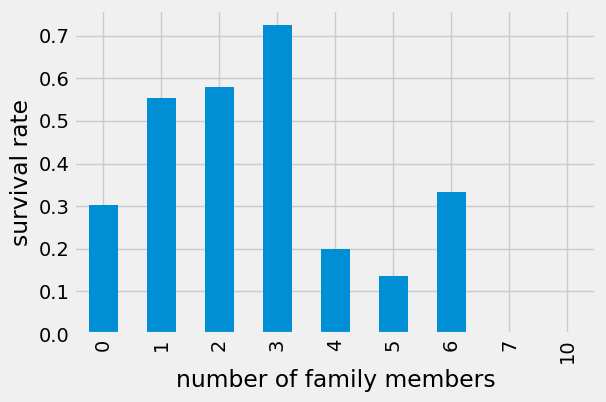

In [23]:
family_survived = pd.pivot_table(train, values = 'Survived', index  = 'Family_count', aggfunc = 'mean')
family_survived.plot.bar(legend=None)
plt.xlabel('number of family members')
plt.ylabel('survival rate')

Looking at the survival rates of the the combined family members, you can see that few of the over 500 passengers with no family members survived, while greater numbers of passengers with family members survived. Only 30% of the passengers who had no family members onboard survived.


In [24]:
# identify percentage of passengers that were alone

def isalone(df):
    if df['Family_count'] > 0:
        df['isalone'] = 0
    else:
        df['isalone'] = 1
    return df

train = train.apply(isalone, axis = 1)
holdout = holdout.apply(isalone, axis = 1)

alone_perc = (train['isalone'].sum() + holdout['isalone'].sum()) /(len(train) + len(holdout))
print('{:.2%} of passengers were alone.'.format(alone_perc))

60.35% of passengers were alone.


In [25]:
# create a select feature function

def select_features(df):
    numerics = ['float', 'int']
    df = df.select_dtypes(include=numerics).dropna(axis = 1)
    all_X = df.drop(["Survived","PassengerId"],axis=1)
    all_y = df["Survived"]
    clf = RandomForestClassifier(random_state = 1)
    selector = RFECV(clf, cv=10)
    selector.fit(all_X,all_y)
    best_columns = list(all_X.columns[selector.support_])
    return best_columns

best_columns = select_features(train)
print(best_columns)

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Young Adult', 'Age_categories_Adult', 'Fare_categories_0-12', 'Fare_categories_12-50', 'Fare_categories_50-100', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'Family_count']


In [26]:
def select_model(df, features):
    all_X = df[features]
    all_y = df["Survived"]
    models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(max_iter = 100),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "liblinear"]
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [4, 6, 9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]
                }

        }
    ]
    for model in models:
        print(model['name'])
        print("-" * len(model['name']))
        grid = GridSearchCV(model['estimator'], param_grid = model['hyperparameters'], cv=10)
        grid.fit(all_X, all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_
        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))
    return models

result = select_model(train, best_columns)

LogisticRegression
------------------
Best Score: 0.821598002496879
Best Parameters: {'solver': 'newton-cg'}

KNeighborsClassifier
--------------------
Best Score: 0.7822971285892635
Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}

RandomForestClassifier
----------------------
Best Score: 0.8350686641697876
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 6}



The best model is the `RandomForestClassifier` with 83.5% accuracy.The best parameters are: 

`{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 6}`

## Submitting to Kaggle

In [32]:
def save_submission_file(model,cols,filename = "submission.csv"):
    holdout_data = holdout[cols]
    predictions = model.predict(holdout_data)
    submissions = pd.DataFrame()
    submissions['PassengerId'] = holdout['PassengerId']
    submissions['Survived'] = predictions
    file = submissions.to_csv(filename, index = False)
    return file

# accessing the best estimators for RandomForestClassifier
best_model = result[2]["best_model"]

save_submission_file(best_model, best_columns)